## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataloader import DataLoader

## Get Dataset

In [2]:
transformer = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download data
train_data = datasets.CIFAR10(root = r"c:\path", download=True, train=True, transform=transformer)
test_data = datasets.CIFAR10(root = r"c:\path", download=True, train=False, transform=transformer)
classes = train_data.classes

# Load data batch
BATCH_SIZE = 16
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

print(f"training data: {len(train_data)}")
print(f"testing data: {len(test_data)}")
print(classes)

Files already downloaded and verified
Files already downloaded and verified
training data: 50000
testing data: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Explore Dataset

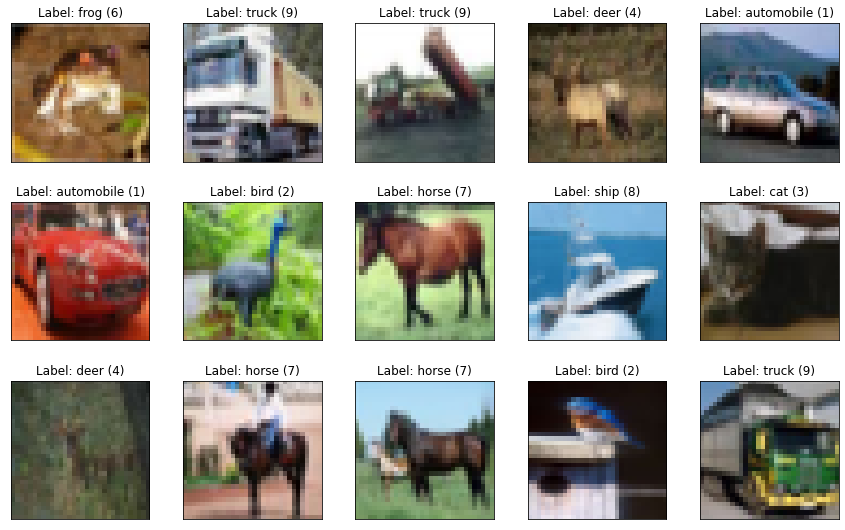

In [3]:
def show_examples(images, start, end, num_row, num_col):
  fig = plt.figure(figsize=(12, 10))
  for i in range(start, end):
    label = images[i][1]
    img = images[i][0] / 2 + 0.5
    title = 'Label: {} ({})'.format(classes[label], str(label))
    plt.subplot(num_row, num_col,i - start +1)
    plt.tight_layout()
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

def show_example(img, label):
  title = 'Label: {} ({})'.format(classes[label], str(label))
  plt.title(title)
  plt.imshow(img.permute(1, 2, 0))

show_examples(train_data, 0, 15, 4, 5)

## Setting up GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Define Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64 * 5 * 5, 512)
    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)
    return x

net = Net().to(device)

In [6]:
# define optimizer and loss
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

## Training and Validation

In [7]:
def forward_pass(X, y, train=False):
  if train:
    net.zero_grad()

  X = X.to(device)
  y = torch.Tensor([np.eye(10)[i] for i in y]) # convert to one hot encoding
  y = y.to(device)

  outputs = net(X.view(-1, 3, 32, 32))
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True) / len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()

  return acc, loss

In [8]:
from torch.utils.data import Subset

# Validation set
def test(size=32):
  test_range = list(range(0, size))
  subset = Subset(test_data, test_range)
  validation_loader = DataLoader(subset, size)
  for data in validation_loader:
    X = data[0]
    y = data[1]
    val_acc, val_loss = forward_pass(X, y)
    return val_acc, val_loss

0.12 tensor(0.0900, device='cuda:0', grad_fn=<MseLossBackward>)


In [9]:
import time

MODEL_NAME = f"model-{int(time.time())}"

def train(net):
  EPOCHS = 20
  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i, data in enumerate(train_loader):
        X = data[0]
        y = data[1]

        acc, loss = forward_pass(X, y, train=True)

        if i % 50 == 0:
          # log the accuracies and loss
          val_acc, val_loss = test(size=100)
          f.write(f"{MODEL_NAME},{round(time.time(),3)},{epoch},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train(net)

In [19]:
# Save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Evaluate Model

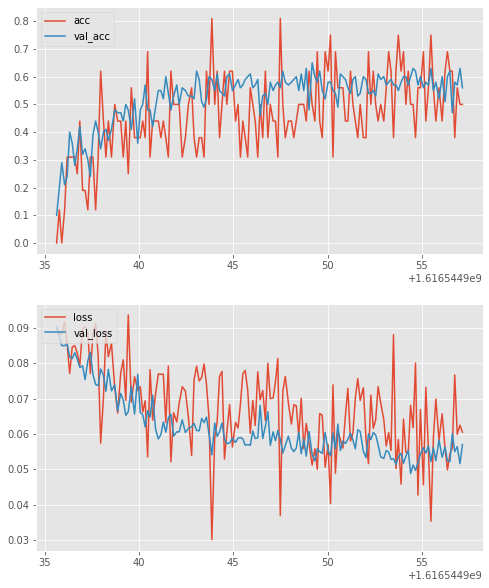

In [24]:
style.use("ggplot")

model_name = "model-1616544935" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, epoch, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure(figsize=(8,10))

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

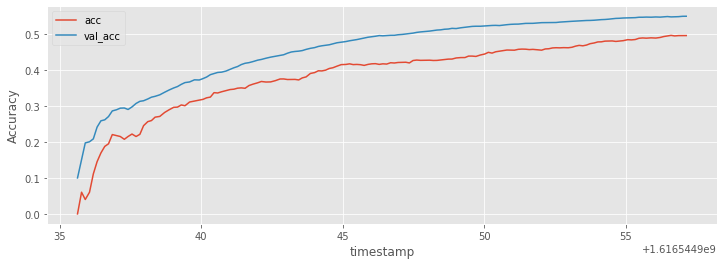

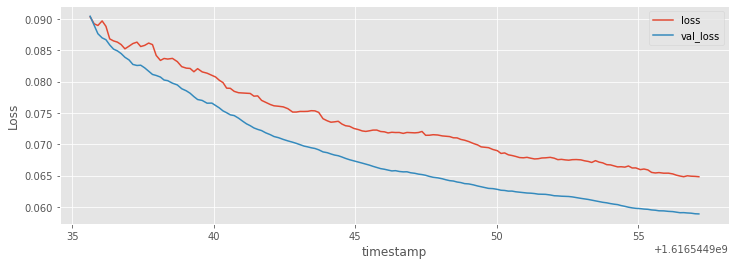

In [17]:
def create_acc_loss_graph(model_name):
    style.use('ggplot')
    data = pd.read_csv('model.log', names=['model_name', 'timestamp', 'epoch', 'acc', 'loss', 'val_acc', 'val_loss'])
    data = data[data.model_name == model_name]
    # Convert to weighted moving average
    for row in ['acc', 'loss', 'val_acc', 'val_loss']:
        data[row] = data[row].ewm(alpha=.01).mean()
    # Plot it
    data[['timestamp', 'acc', 'val_acc']].plot(x='timestamp', figsize=(12,4))
    plt.ylabel('Accuracy')
    data[['timestamp', 'loss', 'val_loss']].plot(x='timestamp', figsize=(12,4))
    plt.ylabel('Loss')
    
create_acc_loss_graph(model_name)

In [22]:
def get_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
        X, y = data[0], data[1]
        X = X.to(device)
        y = torch.Tensor([np.eye(10)[i] for i in y]) # convert to one hot encoding
        y = y.to(device)

        outputs = net(X.view(-1, 3, 32, 32))
        matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
        correct += matches.count(True)
        total += len(matches)

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

get_accuracy(net)

Accuracy of the network on the 10000 test images: 66 %
